This notebook provides an implementation for the paper EFFICIENT AND SCALABLE GRAPH GENERATION THROUGH ITERATIVE LOCAL EXPANSION: [https://arxiv.org/pdf/2312.11529](https://arxiv.org/pdf/2312.11529)

In [1]:
!pip3 install -q torch_geometric
!pip3 install -q diffusers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 23.9 MB/s eta 0:00:0000:01


# Import required librairies

In [89]:
import numpy as np
import math
from pprint import pprint

import torch
from torch.nn import Dropout, LayerNorm, Linear, Module, ModuleList, Sequential, ReLU
from torch.utils.data import IterableDataset
from torch.utils.data import DataLoader as torchDataLoader
import torch.nn.functional as F

import torch_geometric
from torch_geometric.utils import get_laplacian
from torch_geometric.data import Data, Batch, DataLoader, InMemoryDataset, download_url 
from torch_geometric.utils import erdos_renyi_graph, to_dense_adj, dense_to_sparse, to_networkx, from_networkx
from torch_geometric.nn import GCNConv, GINConv, GATConv

import networkx as nx
import matplotlib.pyplot as plt
import os

from diffusers import DDPMScheduler

In [3]:
print("torch_geometric version:", torch_geometric.__version__)
print("torch version:", torch.__version__)

torch_geometric version: 2.6.1
torch version: 2.6.0+cu124


# Creating datasets for training

## Erdos renyi dataset

In [4]:
def generate_erdos_renyi_graphData(num_nodes=20, p=0.3):
    edge_tensor = erdos_renyi_graph(num_nodes, p, directed=False)  # shape [2, num_edges]

    # Create graph nodes, values all 0
    nodes = torch.zeros((num_nodes, 1)) # shape [num_nodes, 1], any node feature is a single scalar 0.
    # each node in this tensor is assigned an id based on its index 0...num_nodes-1 
    # these ids are the ones used in edge_tensor, it is possible that there are no edges... 
    
    # Create Data object for graph
    graphData = Data(x=nodes, edge_index=edge_tensor)
    
    return graphData

graphDataset = generate_erdos_renyi_graphData()
# G = to_networkx(graph, to_undirected=True)
# plt.figure()
# nx.draw(G, with_labels=True, node_size=500)
# plt.show()

In [5]:
# inspiration from https://pytorch-geometric.readthedocs.io/en/latest/tutorial/create_dataset.html#creating-in-memory-datasets

class ErdosRenyiDataset(InMemoryDataset):
    def __init__(self, root, num_graphs=100, transform=None, pre_transform=None, pre_filter=None):
        self.num_graphs = num_graphs

        super().__init__(root, transform, pre_transform, pre_filter)

        # Generate dataset if not done already, else load it
        processed_path = self.processed_paths[0]
        if not os.path.exists(processed_path):
            print("Creating dataset")
            self.process()
        else:
            print("Dataset already exists, loading it...")

        self.load(self.processed_paths[0]) # populates self.data
        print("Done.")

        """
        self.load will create objects:
        
        self.slices = {
          'x':          tensor([0, 2, 5, 6]),   # node feature offsets
          'edge_index': tensor([0, 1, 3, 4]),   # edge index offsets
        }

        self.data = {
          'x':          (total_num_nodes, num_node_features) # concatenation of all graphs nodes
          'edge_index': (2, total_num_edges) # concatenation of all graph edges
        }
        """

    @property
    def processed_file_names(self):
        return ['data.pt']

    def process(self):
        data_list = []

        for i in range(self.num_graphs):
            data_list.append(generate_erdos_renyi_graphData())

        if self.pre_filter:
            data_list = [d for d in data_list if self.pre_filter(d)]
            
        if self.pre_transform:
            data_list = [self.pre_transform(d) for d in data_list]

        self.save(data_list, self.processed_paths[0]) # Runs: data, slices = cls.collate(data_list) and saves these objects

In [6]:
!rm -rf /kaggle/working/data/ER/processed
erdos_renyi_dataset = ErdosRenyiDataset(root='data/ER', num_graphs=100)

Dataset already exists, loading it...
Done.


Processing...
Done!


In [7]:
print(f"Number of graphs: {len(erdos_renyi_dataset)}")

for g in range(4):
    edge_index = erdos_renyi_dataset[g].edge_index

Number of graphs: 100


In [8]:
edge_index[:, :1]

tensor([[0],
        [2]])

## Planar graph dataset (generated with plantri)

Command             | Triangulations Written | CPU Time (sec)
--------------------|------------------------|---------------
./plantri -c3 10    | 233                    | 0.00
./plantri -c3 11    | 1,249                  | 0.02
./plantri -c3 12    | 7,595                  | 0.04
./plantri -c3 13    | 49,566                 | 0.16
./plantri -c3 14    | 339,722                | 1.11
./plantri -c3 15    | 2,406,841              | 8.01
./plantri -c3 16    | 17,490,241             | 61.98
./plantri -c3 17    | 129,664,753            | 504.53

In [9]:
import networkx as nx

def graph6_to_data(g6_path):
    print(f"Loading graphs from {g6_path}")
    
    with open(g6_path, "rb") as f:
        graph_nx = nx.read_graph6(f)

    print(f"Read {len(graphs_nx)} graphs from {g6_path}")
    return graphs_nx

In [10]:
# inspiration from https://pytorch-geometric.readthedocs.io/en/latest/tutorial/create_dataset.html#creating-in-memory-datasets

class PlanarDataset(InMemoryDataset):
    def __init__(self, root, g6_dir=None, transform=None, pre_transform=None, pre_filter=None):

        g6_files = [os.path.join(g6_dir, f) for f in os.listdir(g6_dir) if f.endswith(".g6")]
        self.g6_files = g6_files
        
        super().__init__(root, transform, pre_transform, pre_filter)

        # Generate dataset if not done already, else load it
        processed_path = self.processed_paths[0]
        if not os.path.exists(processed_path):
            print("Creating dataset")
            self.process()
        else:
            print("Dataset already exists, loading it...")

        self.load(self.processed_paths[0]) # populates self.data
        print("Done.")

        """
        self.load will create objects:
        
        self.slices = {
          'x':          tensor([0, 2, 5, 6]),   # node feature offsets
          'edge_index': tensor([0, 1, 3, 4]),   # edge index offsets
        }

        self.data = {
          'x':          (total_num_nodes, num_node_features) # concatenation of all graphs nodes
          'edge_index': (2, total_num_edges) # concatenation of all graph edges
        }
        """

    @property
    def processed_file_names(self):
        return ['data.pt']

    def process(self):
        data_list = []

        for file in self.g6_files:
            nx_graphs = graph6_to_data(file)
            data_list += [from_networkx(g) for g in nx_graphs]

        if self.pre_filter:
            data_list = [d for d in data_list if self.pre_filter(d)]
            
        if self.pre_transform:
            data_list = [self.pre_transform(d) for d in data_list]

        self.save(data_list, self.processed_paths[0]) # Runs: data, slices = cls.collate(data_list) and saves these objects

In [11]:
#planar_dataset = PlanarDataset(root='data/PL', g6_dir="/kaggle/input/planar-graphs-g6-dataset")

# Coarsening sampling

We need to sample coarsening sequences from $\Pi_F(G)$ that only use contraction sets in $F(G) = \mathcal{E}$, meaning each coarsening step only merges some edges of the graph. 

We sample in $\Pi_F(G)$ by sampling coarsening sequences from a "latent" distribution $q(\pi | G)$. To sample from $q(\pi | G)$, we associate a cost to each possible coarsening set at all coarsening steps, for now the uniform cost.

The below function extracts all possible coarsening sets at a given step (given a graph).

tensor([[ 0,  1],
        [ 0,  6],
        [ 0,  7],
        [ 0,  8],
        [ 0, 10],
        [ 0, 16],
        [ 1,  0],
        [ 1,  8],
        [ 1, 14],
        [ 1, 18]])
Total number of nodes: 20


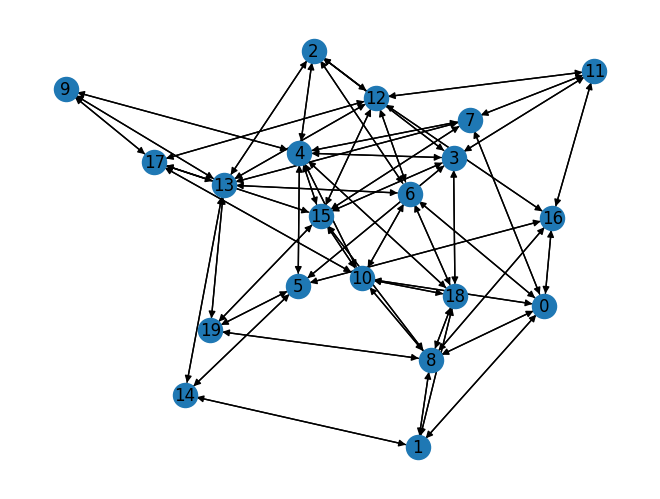

In [12]:
def get_candidate_contraction_sets(G: Data):
    # make sure no self loop on nodes here!
    edge_index = G.edge_index # 2, num_edges (tensor)
    u, v       = edge_index[0], edge_index[1]

    # remove self edges
    nonself = (u != v)
    u_ns, v_ns = u[nonself], v[nonself]

    candidates = torch.stack([u_ns, v_ns], dim=1)
    return candidates

# test
test_graph = erdos_renyi_dataset[10]
nx.draw(to_networkx(test_graph), with_labels=True)

test_candidates = get_candidate_contraction_sets(test_graph)
print(test_candidates[:10])

test_current_num_nodes = test_graph.num_nodes
print("Total number of nodes:", test_current_num_nodes)

The below function creates a dense adjency matrix given a graph by looking at all of its edges.

In [13]:
def get_graph_adj(edge_index: torch.LongTensor, num_nodes: int):
    adj = to_dense_adj(edge_index, max_num_nodes=num_nodes)
    adj = adj[0]
    return adj

# test
test_graph_adj = get_graph_adj(test_graph.edge_index, test_graph.num_nodes)
#indices = (graph_adj == 1).nonzero(as_tuple=False)
print(test_graph_adj)

tensor([[0., 1., 0., 0., 0., 0., 1., 1., 1., 0., 1., 0., 0., 0., 0., 0., 1., 0.,
         0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
         1., 0.],
        [0., 0., 0., 1., 1., 0., 1., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0.,
         0., 0.],
        [0., 0., 1., 0., 1., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0.,
         1., 0.],
        [0., 0., 1., 1., 0., 1., 0., 1., 0., 1., 1., 0., 0., 0., 0., 1., 0., 0.,
         1., 0.],
        [0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0.,
         0., 1.],
        [1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 1., 0., 0., 0., 0.,
         1., 0.],
        [1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 1., 0., 0.,
         0., 0.],
        [1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0.,
         1., 1.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1.,
         0., 0.],
        [1

<span style="color:red">The uniform cost should be replaced by  local-variation cost of Loukas (2018) from the paper otherwise model won't train well!</span>

In [14]:
def get_uniform_cost(candidate_contractions: torch.LongTensor, graphData: Data): # can also be based on G0, P1...P{l-1}
    # graphData not used, just used for compatibility
    num_candidates = candidate_contractions.shape[0]

    return torch.tensor([np.random.rand() for _ in range(num_candidates)], dtype=torch.float32)
      
# test
get_uniform_cost(test_candidates, test_graph)

tensor([0.2982, 0.9219, 0.3122, 0.3660, 0.1978, 0.5084, 0.3807, 0.7898, 0.1981,
        0.1410, 0.2428, 0.5628, 0.8280, 0.6611, 0.2630, 0.7006, 0.0212, 0.5442,
        0.5513, 0.9947, 0.0779, 0.2307, 0.3670, 0.6077, 0.4188, 0.8371, 0.9833,
        0.1824, 0.9991, 0.9355, 0.6091, 0.2565, 0.1173, 0.2130, 0.3995, 0.0884,
        0.4623, 0.8650, 0.2252, 0.1475, 0.0173, 0.6202, 0.5222, 0.5304, 0.0761,
        0.9625, 0.7517, 0.1881, 0.6812, 0.7388, 0.2086, 0.6196, 0.7151, 0.7984,
        0.4271, 0.3923, 0.4116, 0.6005, 0.4027, 0.4623, 0.9932, 0.5252, 0.5589,
        0.8257, 0.9076, 0.3878, 0.0827, 0.9087, 0.8414, 0.0344, 0.2287, 0.8764,
        0.8647, 0.9181, 0.1392, 0.0376, 0.1296, 0.1986, 0.6782, 0.8839, 0.9699,
        0.5940, 0.8205, 0.5406, 0.4732, 0.6786, 0.2178, 0.6597, 0.0762, 0.7867,
        0.2924, 0.2730, 0.7791, 0.3400, 0.8103, 0.7553, 0.1200, 0.1014, 0.0313,
        0.7134, 0.5780, 0.0875, 0.8427, 0.8246, 0.0178, 0.6873, 0.3602, 0.3608,
        0.6442, 0.5951, 0.7652, 0.7292])

<span style="color:red"> Better cost function from the paper, written with chatgpt this is probably wrong and needs to be fixed!!!!</span>

In [15]:
def get_local_variation_cost(
    candidate_contractions: torch.LongTensor,   # [E', 2]  candidate contractions
    graphData: Data,
    k: int = 8,                     # how many eigenvectors to keep
) -> torch.Tensor:                  # → [E']  cost per edge
    """
    Cheap surrogate of Loukas' local-variation cost.
    Computes ‖A[u]-A[v]‖₂ for every candidate edge (u,v).
    """
    edge_index = graphData.edge_index
    num_nodes = graphData.num_nodes
    
    # 1) Dense Laplacian (OK for N≲2 000; fall back to sparse Lanczos if larger)
    adj = get_graph_adj(edge_index, num_nodes)
    deg = adj.sum(1)
    L   = torch.diag(deg) - adj

    # 2) First-k eigenvectors
    evals, evecs = torch.linalg.eigh(L)         # full eig. (CPU); small graphs only
    A = evecs[:, :min(k, num_nodes-1)]          # [N, k]

    # 3) Euclidean distance row-by-row
    Au, Av = A[candidate_contractions[:,0]], A[candidate_contractions[:,1]]
    costs  = torch.linalg.norm(Au - Av, dim=1)  # [E']
    return costs

# test
get_local_variation_cost(test_candidates, test_graph)

tensor([0.5311, 0.5576, 0.8091, 0.2932, 0.3432, 0.7113, 0.5311, 0.5807, 0.9562,
        0.5886, 0.6344, 0.6248, 0.4224, 0.5631, 0.6141, 0.6344, 0.3079, 0.5908,
        0.8267, 0.6193, 0.5024, 0.6248, 0.3079, 0.6364, 0.7550, 0.8741, 0.4599,
        0.3972, 0.3859, 0.5908, 0.6364, 0.9761, 0.7973, 0.8318, 0.5576, 0.4224,
        0.3844, 0.3858, 0.4853, 0.6057, 0.8091, 0.7550, 0.7293, 0.7441, 0.5995,
        0.2932, 0.5807, 0.3222, 0.4366, 0.7121, 0.4997, 0.7635, 0.8741, 0.9434,
        0.8303, 0.3432, 0.4599, 0.3844, 0.3222, 0.3269, 0.5182, 0.3948, 0.8267,
        0.7293, 0.7703, 0.8277, 0.5631, 0.3858, 0.7703, 0.3894, 0.5485, 0.6762,
        0.4446, 0.6141, 0.4853, 0.7441, 0.9434, 0.3894, 0.8197, 0.3280, 0.8297,
        0.9562, 0.9761, 0.8197, 0.6193, 0.3972, 0.5995, 0.4366, 0.3269, 0.5485,
        0.5298, 0.6628, 0.7113, 0.7973, 0.7121, 0.8277, 0.6762, 0.8303, 0.5182,
        0.4446, 0.3280, 0.5298, 0.5886, 0.5024, 0.3859, 0.6057, 0.4997, 0.3948,
        0.8318, 0.7635, 0.8297, 0.6628])

Below is the implementation of the rnd_greedy_min_cost_part algorithm 2 from the paper. Basically this algorithm runs at each step, and given number of nodes to remove, iteratively selectes the best contraction set (edges in our case) to use for coarsening, until the number of nodes to remove is obtained.

In [16]:
def rnd_greedy_min_cost_part(
    candidate_contractions: torch.LongTensor, 
    cost_function, 
    current_graph, # added this parameter to compute cost, it contains current_graph on which coarsening is done
    num_nodes_to_remove: int, 
    current_num_nodes: int,
    rand_lambda: float = 1.0,
):
    """
    Algo 2
    candidate_contractions [num_candidates, 2] each candidate is a pair of nodes (edge)
    Greedily picks contraction candidates until at least num_nodes_to_remove are merged.
    """

    num_candidates = candidate_contractions.size(0)    
    alive = torch.ones(num_candidates, dtype=torch.bool) # check for already selected contractions, True means not selected
    marked  = torch.zeros(current_num_nodes, dtype=torch.bool) # mark nodes already contracted...
    
    costs  = cost_function(candidate_contractions, current_graph)
    
    # each cost is a rand float between 0 and 1    

    picked = [] # picked contractions idx
    removed = 0

    #print(f"inside rnd_greedy_min_cost_part: i need to remove {num_nodes_to_remove} nodes")
    while (removed < num_nodes_to_remove and alive.any()):
        masked_costs = costs.masked_fill(~alive, float('inf'))
        idx = torch.argmin(masked_costs).item()
        
        if torch.rand(1).item() > rand_lambda: # simulate Bernoulli, after selecting an edge to remove, sample a Bernoulli and while it is not 0 never select it again and continue process
            alive[idx] = False
            continue 

        selected_nodes = candidate_contractions[idx] # this contains the selected edge (pair of nodes) to remove
        
        if marked[selected_nodes].any(): # maybe one of the two selected nodes is already used in some other edge that needs to be removed, then never select edge again and continue process
            alive[idx] = False
            continue

        # otherwise mark it as selected set both of the nods to unalive and continue
        
        marked[selected_nodes] = True
        alive[idx] = False
        picked.append(idx)
        #print(f"We find a new edge to remove: {candidate_contractions[idx]}, removing it will remove: {selected_nodes.numel() - 1} nodes.")
        removed +=  selected_nodes.numel() - 1 # merging always keeps one node
        #print(f"inside rnd_greedy_min_cost_part: fo far i removed {removed} nodes.")

    #print(f"I might have stopped because alive.any(): {alive.any()}")
    if picked:
        picked_idx = torch.tensor(picked, dtype=torch.long)
        return candidate_contractions[picked_idx]
    else:
        print("rnd_greedy_min_cost_part Error")

# test
# for remove_n in range(1, current_num_nodes // 2): # max number of removable nodes
#     test_partitioning = rnd_greedy_min_cost_part(test_candidates, get_cost, remove_n, current_num_nodes)
#     print(f"Removed {remove_n} nodes with contractions: {test_partitioning}")
    
test_num_nodes_to_remove = 2
# uniform cost also possible with  get_uniform_cost instead of local_variation_costs
test_partitioning = rnd_greedy_min_cost_part(test_candidates, get_local_variation_cost, test_graph, test_num_nodes_to_remove, test_current_num_nodes)
print(test_partitioning)

tensor([[0, 8],
        [3, 4]])


Below is a visualization function that assigns a unique color to each cluster id (as long as there are less than 34 clusters in total), and then displays the graph by coloring clusters (all nodes in a given cluster will share that cluster color). 

In [17]:
def visualize_clusters(G: Data, partitioning: torch.Tensor):
    # Convert to NetworkX
    if getattr(G, 'edge_attr', None) is not None:
        G_nx = to_networkx(G, to_undirected=True, edge_attrs=["edge_attr"])
        raw_attrs = {
            (u, v): int(d["edge_attr"])
            for u, v, d in G_nx.edges(data=True)
        }
    else:
        G_nx = to_networkx(G, to_undirected=True)
        raw_attrs = {}

    # Create a color map for each node
    color_map = ['lightgray'] * G.num_nodes  # default color

    # Assign a unique color for each cluster
    colors = [
        'red', 'green', 'blue', 'orange', 'purple', 'cyan', 'yellow', 'brown',
        'pink', 'olive', 'chocolate', 'lime', 'navy', 'teal', 'coral', 'gold',
        'magenta', 'orchid', 'salmon', 'darkgreen', 'deepskyblue', 'slateblue',
        'violet', 'maroon', 'turquoise', 'indigo', 'darkorange', 'crimson',
        'steelblue', 'darkviolet', 'khaki', 'cadetblue', 'hotpink', 'mediumseagreen'
    ]

    cluster_id_to_color = {}
    
    for cluster_id, cluster in enumerate(partitioning):
        color = colors[cluster_id % len(colors)]
        cluster_id_to_color[cluster_id] = color
        for node in cluster.tolist():
            color_map[node] = color
        print(f"Cluster {cluster_id} has color {colors[cluster_id % len(colors)]}")

    edge_colors = []
    for u, v in G_nx.edges():
        a = raw_attrs.get((u, v), None)
        edge_colors.append('red' if a == -1 else 'black')

    # Draw the graph
    pos = nx.spring_layout(G_nx, seed=42)
    nx.draw(G_nx, pos, node_color=color_map, with_labels=True, edge_color=edge_colors)
    plt.show()

    return cluster_id_to_color

Cluster 0 has color red
Cluster 1 has color green


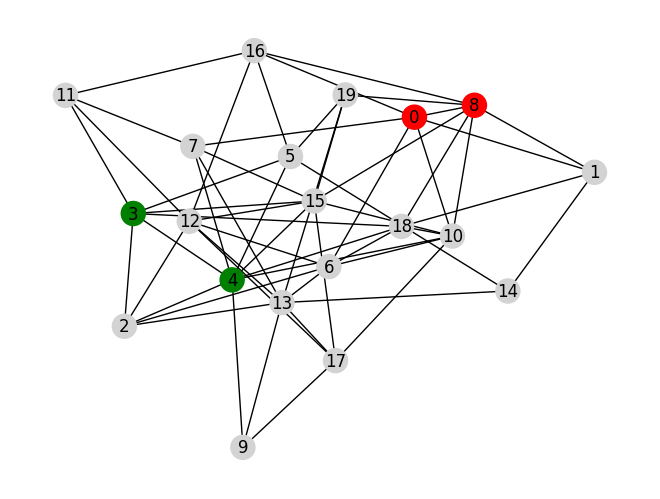

Cluster 0 has color red


In [18]:
test_cluster_id_to_color = visualize_clusters(test_graph, test_partitioning)
print(f"Cluster 0 has color {test_cluster_id_to_color[0]}")

In [19]:
def has_edge_undirected(edge_index, u, v):
    src, dst = edge_index
    return ((src == u) & (dst == v)).any() or ((src == v) & (dst == u)).any()

has_edge_undirected(test_graph.edge_index, 3, 5)

tensor(True)

The below function completes a partitioning tensor containing all coarsening sets (pairs of nodes forming an edge that need to be merged) with the remaining sets that will not be merged for future code compatibility. The remaining sets not to be merged will all contain leftover nodes stacked with themselves, and concatenated at the end of the partitioning tensor. For instance one left over node i will be concatenated as [i, i].

In [20]:
def augment_with_singletons(partitioning: torch.LongTensor, num_nodes: int, debug=False):
    """
    Given partitioning of shape [P,2]
    return a new LongTensor of shape [P+U, K'] where rows 0..P-1
    are your old clusters, and rows P..P+U-1 each contain exactly
    one leftover node as a single cluster.
    """
    # flatten and find which nodes were clustered
    clustered = partitioning.unique() # no dim specified -> unique of the flattened partitioning
    num_initial_clusters = partitioning.shape[0]
    
    all_nodes = torch.arange(num_nodes, device=partitioning.device)
    
    mask = torch.ones(num_nodes, dtype=torch.bool, device=partitioning.device)
    mask[clustered] = False
    
    leftover = all_nodes[mask]  # shape [U]

    # now make each leftover its own cluster of size 1, with itself, little trick
    singletons = torch.stack([leftover, leftover], dim=1) # [U, 2]
    
    if singletons.numel() > 0:
        partitioning = torch.cat([partitioning, singletons], dim=0)

        if debug:
            for i, node_id in enumerate(leftover.tolist()):
                cluster_id = num_initial_clusters + i
                print(f"Leftover node {node_id} assigned to singleton cluster {cluster_id}")

    return partitioning # ideally also explain what id each solo cluster got for coloring later!

# test 
print(f"Number of clusters before: {test_partitioning.shape[0]}")
test_augmented_partitioning = augment_with_singletons(test_partitioning, test_current_num_nodes, debug=True)
print(f"Number of clusters after: {test_augmented_partitioning.shape[0]}")

Number of clusters before: 2
Leftover node 1 assigned to singleton cluster 2
Leftover node 2 assigned to singleton cluster 3
Leftover node 5 assigned to singleton cluster 4
Leftover node 6 assigned to singleton cluster 5
Leftover node 7 assigned to singleton cluster 6
Leftover node 9 assigned to singleton cluster 7
Leftover node 10 assigned to singleton cluster 8
Leftover node 11 assigned to singleton cluster 9
Leftover node 12 assigned to singleton cluster 10
Leftover node 13 assigned to singleton cluster 11
Leftover node 14 assigned to singleton cluster 12
Leftover node 15 assigned to singleton cluster 13
Leftover node 16 assigned to singleton cluster 14
Leftover node 17 assigned to singleton cluster 15
Leftover node 18 assigned to singleton cluster 16
Leftover node 19 assigned to singleton cluster 17
Number of clusters after: 18


The below function builds a matrix P mapping all nodes to their clusters (left over nodes are considered as single node clusters) returns [num_clusters, N] for N nodes.

In [21]:
def build_P(num_nodes: int,
            partitioning: torch.Tensor):
    """
    num_nodes: N
    partitioning: list of LongTensors, each contains original node‑indices cluster (max 2 nodes per cluster since we only consider edges).
    Returns P of shape [num_clusters, N], where P[c,i]=1 if i belongs to coarse‑node c.
    """
    num_clusters = len(partitioning)

    P = torch.zeros((num_clusters, num_nodes), dtype=torch.float32)
    for c, nodes in enumerate(partitioning):
        P[c, nodes] = 1.0
    return P

# test
test_P = build_P(test_current_num_nodes, test_augmented_partitioning)
print(test_P)

tensor([[1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.],
        [0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
         0., 0.],
        [0

Each row corresponds to one cluster id, each column corresponds to one node. This can be reused to compute the expansion step GT as each cluster super node will need to be expanded back to however many nodes it contains.

The below function creates an adjency matrix for clusters. Two clusters which initially contained nodes connected to each other will end up connected. Self loops for one cluster are removed by filling the diagonal of this matrix with 0s.

In [22]:
def get_cluster_adj(P: torch.FloatTensor,
                        A: torch.FloatTensor):
    # P: [C, N]; A: [N, N]
    M = P @ A @ P.t()       # [C, C], computes inter cluster links, if any two clusters initially had nodes connected they will be connected
    M.fill_diagonal_(0)
    return (M > 0).to(torch.float32)

# test
test_cluster_adj = get_cluster_adj(test_P, test_graph_adj)
print(test_cluster_adj)

tensor([[0., 0., 1., 0., 0., 1., 1., 0., 1., 0., 0., 0., 0., 1., 1., 0., 1., 1.],
        [0., 0., 0., 1., 1., 0., 1., 1., 1., 1., 0., 0., 0., 1., 0., 0., 1., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0.],
        [0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 1.],
        [1., 0., 0., 1., 0., 0., 0., 0., 1., 0., 1., 1., 0., 0., 0., 0., 1., 0.],
        [1., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 1., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0.],
        [1., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 1., 0.],
        [0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 1., 0., 1., 0., 0., 0., 1., 0., 1., 0., 1., 1., 1., 0., 0.],
        [0., 0., 0., 1., 0., 1., 1., 1., 0., 0., 1., 0., 1., 0., 0., 1., 0., 1.],
        [0., 0.,

The below function coarsens a graph given a partitioning containing coarsening sets (a set can be a cluster containing two nodes to merge, or a left over node copied twice that shouldn't be merged). It uses previous functions to returned the coarsened graph as well as the node-cluster mapping matrix that was used to build it.

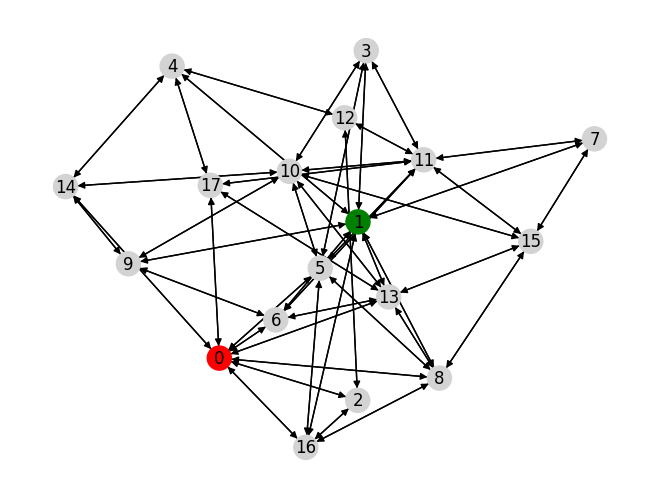

In [23]:
def coarsen_graph(G: Data, partitioning: torch.LongTensor):
    """
    Merge each row of partitioning into a single super‐node.
    Unclustered nodes are nodes j not appearing in any row of partitioning.
    Edges between any two super‐nodes exist iff any member nodes in both were previously connected in G.
    G{l}->G{l+1}
    """
    
    N = G.num_nodes

    augmented_partitioning = augment_with_singletons(partitioning, N)
    
    P = build_P(N, augmented_partitioning) # map nodes to clusters
    graph_adj = get_graph_adj(G.edge_index, N) # get initial graph adjency
    cluster_adj = get_cluster_adj(P, graph_adj) # get clusters adjency

    edge_index, edge_attr = dense_to_sparse(cluster_adj) # convert cluster adj to list of edges
    num_clusters = cluster_adj.size(0)
    
    x = torch.zeros((num_clusters, 1), dtype=torch.float32) # creates a list of cluster nodes
    return Data(x=x, edge_index=edge_index, num_nodes=num_clusters), P # returns a new graph using list of cluster nodes and how they should be connected + the node-cluster mapping matrix 

# test
test_coarsened_graph, test_P = coarsen_graph(test_graph, test_partitioning)

def get_coarse_node_colors(num_clusters: int, cluster_id_to_color: dict) -> list[str]:
    """
    Returns a list of colors for super-nodes in the coarsened graph.
    Each super-node corresponds to a cluster ID.
    """
    color_map = []
    for cluster_id in range(num_clusters):
        color = cluster_id_to_color.get(cluster_id, 'lightgray')
        color_map.append(color)
    return color_map

test_num_clusters = test_coarsened_graph.num_nodes
test_coarse_colors = get_coarse_node_colors(test_num_clusters, test_cluster_id_to_color)

# Step 3: Plot the coarsened graph
nx.draw(to_networkx(test_coarsened_graph), with_labels=True, node_color=test_coarse_colors)

A sequence of coarsening steps will always reach a single node graph eventually since the starting graph is fully connected and the only way to reach one node is to merge a graph containing two nodes (one edge).

In [24]:
curr = 1
for i in range(10):
    print(curr)
    curr = curr-math.ceil(0.10*curr) # math.ceil(0.10*curr) represents the number of nodes to remove, it is computed in the algorithm that follows.

1
0
0
0
0
0
0
0
0
0


The below function implements rnd_red_seq (algorithm 1) from the paper. It takes as input the initial graph and returns the list of coarsened graphs at each step up to the final single node graph, as well as the contractions history (the node-cluster mappings for building each intermediate coarsened graph).

In [25]:
def rnd_red_seq(G0: Data, min_red_frac=0.1, max_red_frac=0.3, debug=False): # it is not possible to remove more than current_num_nods//2 with edge contraction
    """
    Algo 1
    Returns random coarsening sequence π = (G0, . . . , GL) ∈ ΠF (G) 
    """

    current_graph = G0
    
    if debug: print(f"Initial graph has {G0.num_nodes} nodes.")
    coarsening_seq = [current_graph] # π, will end up containing (G0...GL)
    l = 0

    contractions_history = [] # will contain (P1...PL-1) where Pi is the partitioning matrix used to coarsen Gi into G{i+1}
    
    while current_graph.num_nodes != 1: # removing % of current_num_nods to current_num_nods will always be bigger than 0 and math.ceil 
        # will end up being one until current_num_nods becomes 1 -> last node will be removed 
        l += 1
        reduction_fraction = torch.tensor([1.0])
        reduction_fraction.uniform_(min_red_frac, max_red_frac)  # ρ

        # f already defined as get_cost, for now does not depend on G0/contractions_history
        num_nodes_to_remove = math.ceil(reduction_fraction * current_graph.num_nodes) # m

        candidates = get_candidate_contraction_sets(current_graph) # F(G{l−1}) fetch all possible contractions
        if candidates.numel() == 0:
            print("Error no more edges to contract in rnd_red_seq")
            break
        
        partitioning_l = rnd_greedy_min_cost_part(
            candidate_contractions=candidates,
            cost_function=get_local_variation_cost,
            current_graph=current_graph,
            num_nodes_to_remove=num_nodes_to_remove,
            current_num_nodes=current_graph.num_nodes
        ) # tensor [C0, C1, …, Ck] # [num_clusters, 2]

        if partitioning_l.numel() == 0:
            print("No contractions picked")
            continue

        # coarsen graph
        if debug: print(f"Coarsening graph and trying to remove {num_nodes_to_remove} nodes.") # sometimes in some shapes such as S3 (star 4 nodes, one central) we cannot remove two nods
            # if we pick the center one...
        current_graph, P = coarsen_graph(current_graph, partitioning_l)
        if debug: print(f"Coarsened graph has {current_graph.num_nodes} nodes.")

        coarsening_seq.append(current_graph)
        contractions_history.append(P) 

    return coarsening_seq, contractions_history

# test
test_coarsening_seq, test_contractions_history = rnd_red_seq(test_graph, debug=True)
print(len(test_coarsening_seq), len(test_contractions_history))

print("\nCoarsening sequence:")
pprint(test_coarsening_seq)

print("\nContractions history:")
pprint(test_contractions_history)

Initial graph has 20 nodes.
Coarsening graph and trying to remove 4 nodes.
Coarsened graph has 16 nodes.
Coarsening graph and trying to remove 3 nodes.
Coarsened graph has 13 nodes.
Coarsening graph and trying to remove 4 nodes.
Coarsened graph has 9 nodes.
Coarsening graph and trying to remove 2 nodes.
Coarsened graph has 7 nodes.
Coarsening graph and trying to remove 2 nodes.
Coarsened graph has 5 nodes.
Coarsening graph and trying to remove 1 nodes.
Coarsened graph has 4 nodes.
Coarsening graph and trying to remove 2 nodes.
Coarsened graph has 3 nodes.
Coarsening graph and trying to remove 1 nodes.
Coarsened graph has 2 nodes.
Coarsening graph and trying to remove 1 nodes.
Coarsened graph has 1 nodes.
10 9

Coarsening sequence:
[Data(x=[20, 1], edge_index=[2, 112]),
 Data(x=[16, 1], edge_index=[2, 80], num_nodes=16),
 Data(x=[13, 1], edge_index=[2, 58], num_nodes=13),
 Data(x=[9, 1], edge_index=[2, 36], num_nodes=9),
 Data(x=[7, 1], edge_index=[2, 24], num_nodes=7),
 Data(x=[5, 1], 

# Retrieving data needed for expansion

In [26]:
for g in erdos_renyi_dataset[0:5]:
    print(g)

Data(x=[20, 1], edge_index=[2, 112])
Data(x=[20, 1], edge_index=[2, 132])
Data(x=[20, 1], edge_index=[2, 92])
Data(x=[20, 1], edge_index=[2, 136])
Data(x=[20, 1], edge_index=[2, 116])


The below function computes the cluster counts (v) given a node/cluster mapping matrix. Since we only use clusters of 1/2 nodes -> we reformulate the problem as classification between -1 if node shouldn't be expanded (cluster size 1) , 1 if node should be expanded (cluster size 2) 

In [27]:
def compute_node_embeddings(P):
    # Gl is coarsened into Glp1 using Pl
    # Pl is given as input
    # output is the expansion vector v used to come back to Gl from Glp1
    cluster_counts = P.sum(dim=1).long() # v_l
    assign = P.argmax(dim=0)
    v = cluster_counts[assign]
    v = v-2
    return v

# test
print("P:")
print(test_P)

test_v = compute_node_embeddings(test_P)
print("Result:\n", test_v)

P:
tensor([[1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.],
        [0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
         0., 0.],
       

The below function expands a coarsened graph based on the node/cluster mapping matrix that was used to obtain that coarsened graph Gc, it returns the adjency matrix of the expanded graph.

In [28]:
def expand_coarsened(Gc: Data, P):
    C, N = P.shape
    expanded_adj = np.zeros((N, N), dtype=int)
    
    coarsened_adj = get_graph_adj(Gc.edge_index, Gc.num_nodes) # [C, C]

    # for each node i find its cluster id
    clusters = P.argmax(dim=0)  # [N]  each in 0..C-1

    # # intercluster connections 
    # for i in range(N):
    #     for j in range(N):
    #         if clusters[i] != clusters[j]:
    #             ci, cj = clusters[i], clusters[j]
    #             if coarsened_adj[ci, cj] == 1:
    #                 expanded_adj[i, j] = 1
    #                 expanded_adj[j, i] = 1
    #         else:
    #             expanded_adj[i, j] = 1
    #             expanded_adj[j, i] = 1

    # np.fill_diagonal(expanded_adj, 0)
    # return expanded_adj
    
    # chatgpt optimized version using broadcasting
    idx_i = clusters.unsqueeze(1)  # [N,1]
    idx_j = clusters.unsqueeze(0)  # [1,N]

    # intercluster mask
    inter_mask = coarsened_adj[idx_i, idx_j].to(torch.int) # [N, N] 
    
    # intracluster mask
    intra_mask = idx_i == idx_j.to(torch.int) # [N, N]

    # combine and zero out diagonal no self loop
    expanded = (inter_mask | intra_mask)
    expanded.fill_diagonal_(False)

    return expanded
    
# test
test_expanded_graph_adj = expand_coarsened(test_coarsened_graph, test_P)
print(test_expanded_graph_adj)

tensor([[0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1],
        [1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0],
        [0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0],
        [0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0],
        [0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1],
        [1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0],
        [1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0],
        [1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1],
        [0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0],
        [1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0],
        [0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0],
        [0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1],
        [0, 1, 0, 0,

<span style="color:red">Should we realy remove self loops here? expanded.fill_diagonal_(False) in the paper diagram for PPGN self loops are kept eventhough the model should learn to remove them of course...</span>

Below is the original test graph that we coarsen using the colored clusters.

Original clustering
Cluster 0 has color red
Cluster 1 has color green


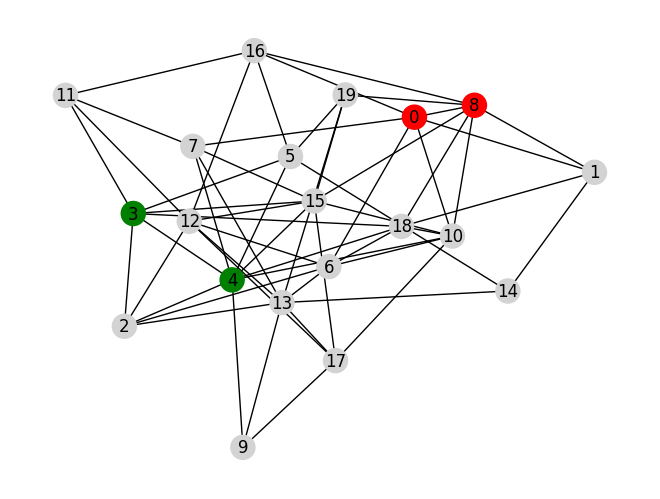

In [29]:
print("Original clustering")
test_cluster_id_to_color = visualize_clusters(test_graph, test_partitioning)

In [30]:
test_cluster_id_to_color

{0: 'red', 1: 'green'}

Below is the coarsened graph obtained from the previous clusters + original graph.

Original coarsened graph


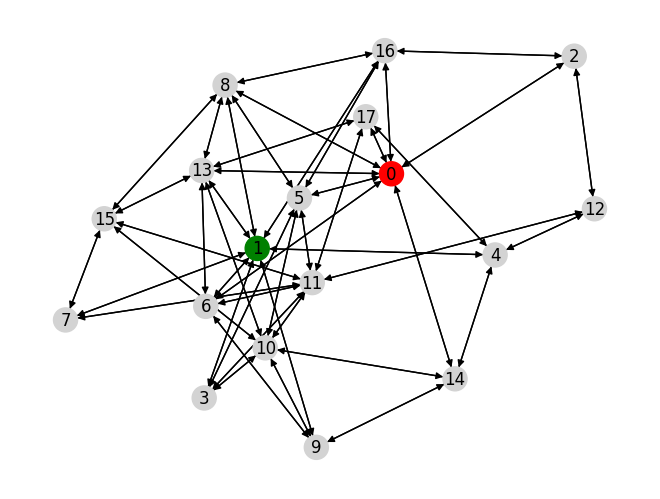

In [31]:
print("Original coarsened graph")
nx.draw(to_networkx(test_coarsened_graph), with_labels=True, node_color=test_coarse_colors)

Below is a function which given the adjency matrix of some expanded graph $\tilde{G}_l$  creates the refined graph Data object $G_l$.  $\tilde{G}_l$ was obtained after expanding some $\tilde{G}_{l+1}$ using $v_{l+1}$. The new graph should contain the same edges as the expanded graph, but with labels indicating whether we should keep (1) or remove/refine them (-1). All edges can be represented as $e_l$. Node embeddings will then contain for each node the future expansion counts required, all node embeddings can therefore be represented as $v_l$ later on.

In [32]:
def refine_expanded_graph(expanded_adj: torch.Tensor, original_adj: torch.Tensor, v: torch.Tensor) -> Data:
    """
    expanded_adj: [N, N] dense adjacency (0/1)
    expanded_adj: [N, N] dense adjacency (0/1)
    
    returns: Data(x=[N,1], edge_index=[2, E])
    """
    edge_index, edge_attr = dense_to_sparse(expanded_adj)

    edge_labels = original_adj[edge_index[0],edge_index[1]].long() # [E]
    edge_labels = edge_labels * 2 - 1 # remap 0/1 to -1/1

    #x = torch.zeros((expanded_adj.size(0), 1), dtype=torch.float)
    x = torch.zeros((expanded_adj.size(0), 1), dtype=torch.float)
    y = v.float()

    return Data(x=x, edge_index=edge_index, edge_attr=edge_labels, y=y)

test_refinedGraphData = refine_expanded_graph(test_expanded_graph_adj, test_graph_adj, test_v)
print(test_refinedGraphData)
print(".x:", test_refinedGraphData.x)
print(".y:", test_refinedGraphData.y)
print("edge_attr:", test_refinedGraphData.edge_attr)

Data(x=[20, 1], edge_index=[2, 130], edge_attr=[130], y=[20])
.x: tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.]])
.y: tensor([ 0., -1., -1.,  0.,  0., -1., -1., -1.,  0., -1., -1., -1., -1., -1.,
        -1., -1., -1., -1., -1., -1.])
edge_attr: tensor([ 1,  1,  1,  1,  1, -1,  1, -1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  1,  1, -1, -1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1,  1,  1,
         1,  1,  1,  1,  1,  1,  1, -1,  1,  1,  1,  1,  1, -1,  1, -1,  1,  1,
         1,  1,  1, -1, -1,  1,  1,  1,  1,  1, -1,  1,  1,  1,  1, -1,  1,  1,
         1,  1,  1,  1,  1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  1,  1,  1,  1,  1,  1,  1,  1, -1,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  1,  1,  1,  1,  1,  1,  1,  

Expanded and refined (red) graph coarsened graph
Cluster 0 has color red
Cluster 1 has color green


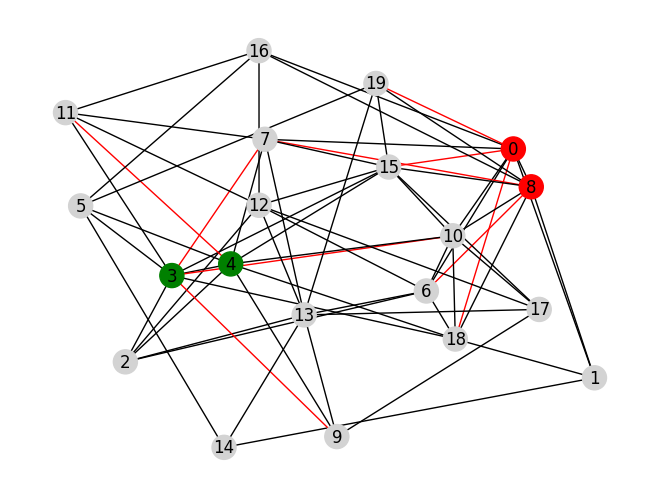

In [33]:
print("Expanded and refined (red) graph coarsened graph")
test_cluster_id_to_color = visualize_clusters(test_refinedGraphData, test_partitioning)

We can extract from the refined graph the vector $e_l$ and for each edge print its -1/1 value.

In [34]:
edge_index = test_refinedGraphData.edge_index   # shape [2, E]
edge_attr  = test_refinedGraphData.edge_attr    # shape [E] or [E,1]

for i in range(edge_index.size(1)):
    u = edge_index[0, i].item()
    v = edge_index[1, i].item()
    a = edge_attr[i].item() if edge_attr.ndim == 1 else edge_attr[i,0].item()
    print(f"Edge ({u:2d}, {v:2d})  → attr = {a}")

Edge ( 0,  1)  → attr = 1
Edge ( 0,  6)  → attr = 1
Edge ( 0,  7)  → attr = 1
Edge ( 0,  8)  → attr = 1
Edge ( 0, 10)  → attr = 1
Edge ( 0, 15)  → attr = -1
Edge ( 0, 16)  → attr = 1
Edge ( 0, 18)  → attr = -1
Edge ( 0, 19)  → attr = -1
Edge ( 1,  0)  → attr = 1
Edge ( 1,  8)  → attr = 1
Edge ( 1, 14)  → attr = 1
Edge ( 1, 18)  → attr = 1
Edge ( 2,  3)  → attr = 1
Edge ( 2,  4)  → attr = 1
Edge ( 2,  6)  → attr = 1
Edge ( 2, 12)  → attr = 1
Edge ( 2, 13)  → attr = 1
Edge ( 3,  2)  → attr = 1
Edge ( 3,  4)  → attr = 1
Edge ( 3,  5)  → attr = 1
Edge ( 3,  7)  → attr = -1
Edge ( 3,  9)  → attr = -1
Edge ( 3, 10)  → attr = -1
Edge ( 3, 11)  → attr = 1
Edge ( 3, 15)  → attr = 1
Edge ( 3, 18)  → attr = 1
Edge ( 4,  2)  → attr = 1
Edge ( 4,  3)  → attr = 1
Edge ( 4,  5)  → attr = 1
Edge ( 4,  7)  → attr = 1
Edge ( 4,  9)  → attr = 1
Edge ( 4, 10)  → attr = 1
Edge ( 4, 11)  → attr = -1
Edge ( 4, 15)  → attr = 1
Edge ( 4, 18)  → attr = 1
Edge ( 5,  3)  → attr = 1
Edge ( 5,  4)  → attr = 1
Edge 

# Creating SignNet node embeddings from graph for conditional diffusion

This code is adapted from their implementation.

In [35]:
class MLP(Module):
    """This block implements the multi-layer perceptron (MLP) module.

    Args:
        in_features (int): Number of features of the input.
        hidden_features (list[int]): List of the hidden features dimensions.
        out_features (int, optional): If not `None` a projection layer is added at the end of the MLP. Defaults to `None`.
        bias (bool, optional): Whether to use bias in the linear layers. Defaults to `True`.
        norm_layer (Module, optional): Normalization layer to use. Defaults to `norm_layer`.
    """

    def __init__(
        self,
        in_features: int,
        hidden_features: list[int],
        out_features: int | None = None,
        bias: bool = True,
        norm_layer=LayerNorm,
    ):
        super().__init__()
        lin_layers = []
        norm_layers = []
        hidden_in_features = in_features
        for hidden_dim in hidden_features:
            lin_layers.append(Linear(hidden_in_features, hidden_dim, bias=bias))
            norm_layers.append(norm_layer(hidden_dim))
            hidden_in_features = hidden_dim

        self.out_layer = (
            Linear(hidden_in_features, out_features, bias=bias)
            if out_features is not None
            else None
        )

        self.lin_layers = ModuleList(lin_layers)
        self.norm_layers = ModuleList(norm_layers)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        for lin, norm in zip(self.lin_layers, self.norm_layers):
            x = lin(x)
            x = norm(x)
            x = torch.relu(x)

        if self.out_layer is not None:
            x = self.out_layer(x)

        return x

In [36]:
class SignNet(Module):
    def __init__(
        self,
        num_eigenvectors: int,
        hidden_features: int,
        out_features: int,
        num_layers: int,
        dropout: float = 0.0,
    ) -> None:
        super().__init__()

        self.in_layer = Linear(2, hidden_features)
        self.conv_layers = ModuleList(
            [
                GINConv(
                    MLP(hidden_features, [hidden_features, hidden_features]),
                    train_eps=True,
                )
                for _ in range(num_layers)
            ]
        )
        self.skip_layer = Linear(hidden_features * (num_layers + 1), hidden_features)
        self.dropout = Dropout(dropout)
        # the following corresponds to the ρ function in the paper
        self.merge_layer = MLP(
            in_features=num_eigenvectors * hidden_features,
            hidden_features=[hidden_features, hidden_features],
            out_features=out_features,
        )

    def forward(self, spectral_features, edge_index):
        """Forward pass of the model.

        Args:
            spectral_features (Tensor): Eigenvalues (repeated) concatenated with eigenvectors. Shape: :math:`(V, num_eigenvectors * 2)`.
            edge_index (Adj): Adjacency matrix given as edge index or sparse tensor. Shape: :math:`(2, E)` or :math:`(V, V)`.

        Returns:
            Tensor: Node features. Shape: :math:`(V, out_features)`.
        """
        # Stack spectral features
        eigenvalues_repeated, eigenvectors = spectral_features.chunk(
            2, dim=-1
        )  # (V, k), (V, k)

        positive_spectral_features = torch.stack(
            [eigenvalues_repeated, eigenvectors], dim=-1
        )  # V, k, 2
        negative_spectral_features = torch.stack(
            [eigenvalues_repeated, -eigenvectors], dim=-1
        )  # V, k, 2
        combined_spectral_features = torch.stack(
            [positive_spectral_features, negative_spectral_features]
        ).transpose(
            1, 2
        )  # 2, k, V, 2

        # Apply layers
        x = self.in_layer(combined_spectral_features)  # 2, k, V, hidden_features
        xs = [x]
        for conv in self.conv_layers:
            # apply conv layer to each spectral feature independently
            x = conv(x=x, edge_index=edge_index)
            xs.append(x)

        # Skip connection
        x = torch.cat(xs, dim=-1)
        x = self.dropout(x)
        x = self.skip_layer(x)  # 2, k, V, hidden_features
        # Make sign invariant
        x = x.sum(dim=0)  # k, V, hidden_features

        # Merge features
        x = x.transpose(0, 1)  # V, k, hidden_features
        x = self.merge_layer(x.reshape(x.size(0), -1))  # V, out_features

        return x

In [37]:
# define model
global_k = 8 # means the model takes as input 2x 32 = 64, we select first 32 eigenvectors for all graphs

# model input should be (V,2k) where k eigenvectors were selected, since some graphs might have less nodes than global_k we pad them with 0s...
# ideally with a big k we always have k>V and for each node the input vector will be 2k with first k values : [lambda 1, ..., lambda V, 0...0,     eigevec_0, ...., eigevec_V, 0...0]

# basically for each node, 
embedding_model = SignNet(
    num_eigenvectors=global_k,
    hidden_features=64,
    out_features=128,
    num_layers=3,
    dropout=0.1
)

In [38]:
def get_spectral_features_torch(data, k=global_k):
    # Get Laplacian
    lap_edge_index, lap_edge_weight = get_laplacian(data.edge_index) # computes laplacian and returns as edge_index with weights on each edge (pair of nodes)
    L_dense = to_dense_adj(lap_edge_index, edge_attr=lap_edge_weight).squeeze(0) # convert to matrix form

    # Compute eigendecomposition
    eigvals, eigvecs = torch.linalg.eigh(L_dense)  # eigenvalues sorted in ascending order, computes all 50 + their corresponding eigen vectors
    # shapes [num_nodes] and [num_nodes, num_nodes] resp. one column = one eigen vector
    
    # Take k smallest eigen values and corresponding vectors
    eigvals = eigvals[1:k+1] # [k,] (remove the 0 eigen value) / [num_nodes-1,] if num_nodes-1<k...
    eigvals = eigvals.unsqueeze(0) #[1,k]
    eigvals = eigvals.repeat(data.num_nodes, 1) # num_nodes, k / num_nodes, num_nodes-1  if num_nodes-1<k...

    eigvecs = eigvecs[:, 1:k+1] # [num_nodes, k] remove eigen vector linked with 0 eigen value /  [num_nodes, num_nodes-1] if num_nodes-1<k
    
    num_nodes = eigvecs.shape[0]
    num_vecs = eigvecs.shape[1] # could be num_nodes-1 and not k if  num_nodes-1<k    

    if num_vecs<k:
        # prepare padding matrix for both eigen values and eigen vectors
        diff = k-num_vecs
        padding = torch.zeros((num_nodes, diff))
        
        eigvals = torch.cat([eigvals, padding], dim=1) # num_nodes, k
        eigvecs = torch.cat([eigvecs, padding], dim=1) # num_nodes, k

    return torch.cat([eigvals, eigvecs], dim=1)


# test
get_spectral_features_torch(test_graph, 100).shape

torch.Size([20, 200])

In [39]:
spectral_features = get_spectral_features_torch(test_graph, k=global_k)
print(spectral_features.shape)

embedding_model.eval()
with torch.no_grad():
    out = embedding_model(spectral_features, test_graph.edge_index)

print(out.shape) # for each node outputs some 128 dimensional embedding

torch.Size([20, 16])
torch.Size([20, 128])


The below function is O(n3)! Can be optimized using scipy.sparse.linalg.eigsh.

In [40]:
def fill_H_embeddings(G_expanded: Data, G_coarsened: Data, Plp1, embedding_model, rand=False):
    """
    Basically calculates embedding from Glp1 graph using embedding_model Signnet and algo5 from paper, then replicates these embeddings inside G_expanded
    all nodes belonging to a coarsened cluster will get that cluster embedding...
    Plp1 is the cluster/node mapping for transition Gl->Glp1

    G_expanded is the graph that needs to be filled!
    """
    num_nodes = G_coarsened.num_nodes
    if rand:
        #H = torch.randn(num_nodes)
        x = torch.randn((G_expanded.num_nodes, 128))
        G_expanded.x = x
        return G_expanded

    else:
        spectral_feats = get_spectral_features_torch(G_coarsened, k=global_k)

        with torch.no_grad():
            H_coarsened = embedding_model(spectral_feats, G_coarsened.edge_index)

        # broadcast using P_l that was used to obtain G_coarsened from G
        cluster_id = Plp1.argmax(dim=0)
        H_expanded = H_coarsened[cluster_id] # Basically all nodes i in some cluster j with embedding Hj, will end up with embedding Hj 
        G_expanded.x = H_expanded # set node embeddings
        
        return G_expanded

# test
test_graph = fill_H_embeddings(test_graph, test_coarsened_graph, test_P, embedding_model)
print(test_graph)

Data(x=[20, 128], edge_index=[2, 112])


# Creating the training dataset

The diffusion model will learn to denoise e_l (refine current graph), and v_l future expansions after refinement to get Gl-1, given the following parameters most contained in refined graph Gl:

* noised el and vl obtained from Gl˜ (noised T times using ddpm scheduler) (from refined graph which edges attr contain -1/1, and .y contains -1/1 for each potential node expansion)
* T
* Gl˜ node embeddings containing info obtained using coarsened Glp1 (.x inside refined graph)

In [58]:
class CoarsenDataset(IterableDataset): # torch dataset
    def __init__(self, graphsDataset, embedding_model, min_red=0.1, max_red=0.3, start=0, end=None):
        super(CoarsenDataset).__init__()
        self.min_red = min_red
        self.max_red = max_red

        self.graphsDataset = graphsDataset
        self.embedding_model = embedding_model
        self.start = start
        self.end = len(graphsDataset) if end is None else end
        
    def __iter__(self):
        iter_start = self.start
        iter_end = self.end
        graphsDataset = self.graphsDataset

        selected_graphs = graphsDataset[iter_start: iter_end]
        
        for G0 in selected_graphs:
            coarsening_seq, contractions_history = rnd_red_seq(G0, self.min_red, self.max_red)
            # coarsening_seq = [G0, G1, ..., G_L]
            # contractions_history = [P1, P2, ..., P_{L}]  where P_l is used for G_{l-1}->G_l
            # P_l are the node-cluster mappings...

            num_initial_nodes = G0.num_nodes # target num nodes
            
            original_adj = get_graph_adj(G0.edge_index, G0.num_nodes)
        
            # to construct each sample we need:
            # from a sequence G{l-1} ---(Pl)---> Gl ----(Plp1)---> Glp1
            
            # first to expand Glp1 using Plp1 -> and obtain Gl˜ before refinement
            # compare Gl˜ and Gl to get refined graph and extract e_l -> add that to graph Gl˜ to obtain refined graph with proper edge attributes which is denoted as Gl
            # Use Pl to compute next node expansion for Gl (the expansion that will lead to G{l-1}˜)

            # for last node we know v=[2]
            # then given refined graphs + node embeddings/edgeattributes resp. G1,G2....,G{l-1} we can learn to create resp. G0, ..., Gl-2
            # we don't need to learn how to create Gl-1 since given any single node graph GL we just duplicate it into two nodes and that gives Gl-1...
            # therefore we can reconstruct any sequence backwards if model learns to reproduce the refinement+future expansion steps...

            for i in range(1, len(contractions_history)-1): # 1, ..., L-2
                Glm1 = coarsening_seq[i-1] # G0, G1, ..., Gl-3
                Gl = coarsening_seq[i] #  G1, G2, ..., Gl-2
                Glp1 = coarsening_seq[i+1] # G2, G3, ..., Gl-1
                Pl = contractions_history[i] # used to coarsen Glm1 into Gl,    P1...Pl-2
                Plp1 = contractions_history[i+1] # used to coarsen Gl into Glp1,   P2, ..., Pl-1

                original_graph_adj_Gl = get_graph_adj(Gl.edge_index, Gl.num_nodes) # original Gl adjency matrix
                expanded_graph_adj_Gl_tilde = expand_coarsened(Glp1, Plp1) # Gl tilde, using actual cluster values, #G1...Gl-2 tilde
                #vlp1 = compute_node_embeddings(Plp1) # extract cluster sizes -1/1 if need to expand, of Glp1
                vl = compute_node_embeddings(Pl) # future node expansions of Gl tilde, used to obtain Glm1

                refined_graph = refine_expanded_graph(expanded_graph_adj_Gl_tilde, original_graph_adj_Gl, vl) # Gl refined version ,  G1, G2, ..., Gl-2
                # data object, is refined G_l containing e_l edge attr 1 keep /-1 remove; future vl expansion labels on each node in .y, missing node embeddings obtained from Glp1 and replicated 
                # across all cluster nodes
                refined_graph = fill_H_embeddings(refined_graph, Glp1, Plp1, embedding_model) # adds all node embeddings inside Gl refined graph according to algo 5, using its later coarsened version Glp1
                # as well as Plp1 transition and the embedding model
            
                yield refined_graph, num_initial_nodes, i 

In [49]:
def coarsen_collate(samples):
    """
    samples: list of tuples (refined_graph, init_num_nodes, level_l)
    returns batch_graph PyG Batch object with all graphs merged;
    init_N      : LongTensor [B]  –  original |V(G0)| for all graphs in batch
    level_l     : LongTensor [B]  –  coarsening depth index l (i from the yield)
    """
    graphs, init_nodes, levels = zip(*samples)

    batch_graph = Batch.from_data_list(graphs)  # automatic concat
    init_N = torch.tensor(init_nodes, dtype=torch.long)
    level_l = torch.tensor(levels, dtype=torch.long)

    return batch_graph, init_N, level_l

In [59]:
dataset = CoarsenDataset(graphsDataset=erdos_renyi_dataset,embedding_model=embedding_model)
loader  = torchDataLoader(dataset,batch_size=4,collate_fn=coarsen_collate,num_workers=0)

In [67]:
for batch_graph, init_N, level_l in loader:
    print("batch_graph: ", batch_graph)
    print("init_N: ", init_N)
    print("level_l ", level_l)
    break

graphs = batch_graph.to_data_list()

print("\nNum nodes in each graph of batch:")
for g in graphs:
    print(g.num_nodes)

batch_graph:  DataBatch(x=[39, 128], edge_index=[2, 206], edge_attr=[206], y=[50], batch=[39], ptr=[5])
init_N:  tensor([20, 20, 20, 20])
level_l  tensor([1, 2, 3, 4])

Num nodes in each graph of batch:
14
11
8
6


In [79]:
print(batch_graph.x.shape)
print(batch_graph.y.shape)
print(batch_graph.edge_index.shape)

torch.Size([39, 128])
torch.Size([50])
torch.Size([2, 206])


# Defining denoising model (GAT)

In [83]:
class Denoiser(Module):
    def __init__(self, in_dim, hid_dim=128, n_heads=4, t_emb_dim=32):
        super().__init__()
        # time / scalar encoders
        self.t_embed   = Linear(1, t_emb_dim)
        self.scalar_ml = Linear(2, t_emb_dim)      # |V(G0)| and level

        # 2-layer GAT encoder
        self.gat1 = GATConv(in_dim + t_emb_dim + t_emb_dim, hid_dim,
                            heads=n_heads, concat=False)
        self.gat2 = GATConv(hid_dim, hid_dim, heads=n_heads, concat=False)

        # node & edge noise heads
        self.node_head = Sequential(Linear(hid_dim, hid_dim),
                                       ReLU(), Linear(hid_dim, 1))
        self.edge_head = Sequential(Linear(2*hid_dim, hid_dim),
                                       ReLU(), Linear(hid_dim, 1))

    def forward(self, data, t_node, t_edge, init_N, level_l):
        # ----  time / scalar embeddings  ------------------------------
        t_feat     = self.t_embed(t_node.unsqueeze(1).float())            # [ΣN,t_emb]
        scalars    = torch.stack([init_N[data.batch].float(),
                                  level_l[data.batch].float()], dim=1)
        s_feat     = self.scalar_ml(scalars)                              # [ΣN,t_emb]

        x0 = torch.cat([data.x, t_feat, s_feat], dim=1)                   # [ΣN,d_in]

        # ----  GAT encoder  -------------------------------------------
        h = self.gat1(x0, data.edge_index)
        h = self.gat2(h,  data.edge_index)                                # [ΣN,hid]

        # ----  node noise prediction  ---------------------------------
        node_eps = self.node_head(h).squeeze(-1)                          # [ΣN]

        # ----  edge noise prediction ----------------------------------
        src, dst = data.edge_index
        edge_h   = torch.cat([h[src], h[dst]], dim=1)                     # [ΣE,2*hid]
        edge_eps = self.edge_head(edge_h).squeeze(-1)                     # [ΣE]

        return node_eps, edge_eps

In [91]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


In [92]:
model  = Denoiser(in_dim=batch_graph.x.size(1)).to(device)
opt    = torch.optim.Adam(model.parameters(), lr=2e-4)

# Training model

In [98]:
T = scheduler.config.num_train_timesteps      # e.g. 1000

for batch_graph, init_N, level_l in loader:   # ← your DataLoader
    batch_graph = batch_graph.to(device)

    # ------------------------------------------------------------ #
    # 1)   sample one timestep per *node* and per *edge*
    # ------------------------------------------------------------ #
    t_node = torch.randint(0, T, (batch_graph.x.size(0),),  device=device)
    t_edge = torch.randint(0, T, (batch_graph.edge_attr.size(0),), device=device)

    # ------------------------------------------------------------ #
    # 2)   add noise
    # ------------------------------------------------------------ #
    clean_v = batch_graph.y.float()                    # [ΣN]
    clean_v = batch_graph.y.float().unsqueeze(-1)
    
    clean_e = batch_graph.edge_attr.float()            # [ΣE]
    clean_e = batch_graph.edge_attr.float().unsqueeze(-1)  # [ΣE, 1]
    
    noise_v = torch.randn_like(clean_v)
    noise_e = torch.randn_like(clean_e)

    v_noisy = scheduler.add_noise(clean_v, noise_v, t_node)
    e_noisy = scheduler.add_noise(clean_e, noise_e, t_edge)

    # overwrite the noisy signals for the model
    batch_graph.v_noisy = v_noisy          # custom attribute
    batch_graph.e_noisy = e_noisy          # re-use edge_attr if you prefer

    # ------------------------------------------------------------ #
    # 3)   forward & loss
    # ------------------------------------------------------------ #
    pred_v_eps, pred_e_eps = model(batch_graph, t_node, t_edge,
                                   init_N.to(device), level_l.to(device))

    loss = (pred_v_eps - noise_v).square().mean() + \
           (pred_e_eps - noise_e).square().mean()

    opt.zero_grad()
    loss.backward()
    opt.step()

RuntimeError: The size of tensor a (29) must match the size of tensor b (40) at non-singleton dimension 0

# Noising v_l and e_l for diffusion 

In [68]:
scheduler = DDPMScheduler(num_train_timesteps=1000, beta_schedule="linear")
scheduler.set_timesteps(1000)

In [69]:
v = torch.rand((4, 10))
t = torch.randint(0, 1000, (4,), dtype=torch.long)  # random timesteps per sample
noise = torch.randn_like(v)

In [70]:
v_t = scheduler.add_noise(v, noise=noise, timesteps=t)
print(v_t)

tensor([[ 0.8702,  0.1778, -0.8498,  0.9055,  0.7453, -1.5304,  0.2434,  0.5382,
         -0.4613,  0.0697],
        [-0.8572, -0.2653,  0.3144, -0.2183, -0.5688,  0.4769,  1.2189, -0.8787,
         -0.0850, -0.8547],
        [ 0.2547, -0.4308,  0.0443,  1.3033, -0.1899, -1.1871, -0.5486,  2.1766,
          0.2003, -0.0337],
        [-0.2706, -0.7267, -1.1116, -0.3359,  1.1809,  0.0590,  1.4291, -0.0421,
         -1.0419,  0.0575]])
